In [1]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
          "spark.sql.execution.arrow.enabled":"true"
         }
}

[I 2023-02-10 14:21:26,028.028 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.execution.arrow.enabled": "true"}, "proxyUser": "assumed-role_fdp_blitvin-Isengard"}

[I 2023-02-10 14:21:26,029.029 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [4]:
pip install boto3 awswrangler yfinance

     |████████████████████████████████| 132 kB 27.7 MB/s eta 0:00:01
     |████████████████████████████████| 267 kB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.4 MB 80.1 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 78.0 MB/s eta 0:00:01
     |████████████████████████████████| 36.0 MB 65.8 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 102.5 MB/s eta 0:00:01
     |████████████████████████████████| 220 kB 98.5 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 506 kB/s  eta 0:00:01
     |████████████████████████████████| 43 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 4.2 MB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 87.8 MB/s eta 0:00:01
     |██████████████████████████████

In [5]:
import pyEX as p
import requests
import json
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools
import datetime
#import awswrangler as wr
import vectorbt as vbt
import pyspark.sql.functions as py_f
import pyspark.sql.types as py_t
import pyspark.sql.window as py_w
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.requests import StockBarsRequest
import pyarrow as pa
import pyarrow.parquet as pq
import boto3
from botocore.exceptions import ClientError
import pyfolio as pf
import scipy.stats as stats

isSandbox = False
if isSandbox:
    token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
    iex_ver = 'sandbox'
else:
    #token ='pk_2e94555e43da4135a6032433c6b18fa5'
    token = 'pk_79d147436c1349f3abbec37591323e52'
    iex_ver = 'stable'
pyEX_cl = p.Client(api_token=token)
timeframe = 'max'

/usr/local/lib/python3.7/site-packages/tzlocal/unix.py:177: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")
/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [6]:
ALPACA_API_KEY_ID = 'AK8MWGDK1GMSP91W1SGM'
ALPACA_API_SECRET_KEY = 'oM5h4WWGfuKrctHWdCmtpwLcOuoV5TLemJ5ImavI'
etf_parquet_file = 's3://fsidatalake/intraday_market_data/etf_30mins.parquet'


In [7]:
if False:
    fx_etf_symbols = [
        'FXA',
        'FXY',
        'FXE',
        'FXB',
        'UUP',
        'FXC',
        'FXF',
    ]
    bitcoin_etf_symbols = ['BITO']
    commod_etf_symbols = [
        'USO',
        'GLD',
        'DBA',
        'DBB',
        'SLV',
    ]
    fi_etf_symbols = [
        'IAGG',
        'AGG',
        'IHY',
        'EMLC',
        'HYG',
    ]
    equity_etf_symbols = [
        'AMJ', 'AMLP', 'ARKF', 'ARKG', 'ARKK', 'ARKQ', 'ARKW', 'BOTZ', 'BUG',
        'CGW', 'CIBR', 'COPX', 'CRBN', 'DRIV', 'EFV', 'EMLP', 'FBT', 'FDN',
        'FIVG', 'FIW', 'FTXG', 'GDX', 'GNR', 'GUNR', 'HACK', 'IAT', 'IBB',
        'ICLN', 'IEO', 'IFRA', 'IGE', 'IGF', 'IGM', 'IGV', 'IHF', 'IHI', 'ITB',
        'ITZ', 'IWD', 'IWN', 'IWS', 'IYT', 'JETS', 'KBWB', 'KOMP', 'KRE',
        'KWEB', 'LCTU', 'LIT', 'MLPA', 'MLPX', 'MOO', 'NFRA', 'OIH', 'PABU',
        'PAVE', 'PBW', 'PEJ', 'PHO', 'PICK', 'PPA', 'QCLN', 'REET', 'REMX',
        'ROBO', 'SCHH', 'SIL', 'SKYY', 'SMH', 'SOXX', 'SRVR', 'TAN', 'URA',
        'URNM', 'VUG', 'XAR', 'XBI', 'XHB', 'XME', 'XOP', 'XSD', 'QQQ', 'EWZ',
        'AAXJ', 'VTI', 'EWJ', 'EWA', 'EWC', 'MCHI', 'EWU', 'EWQ', 'EWG', 'FM',
        'EIS'
    ]
    sectors = [
        'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK',
        'XLU'
    ]
    bench_symbol = ['SPY', 'QQQ', 'IVV']
    all_symbols = fx_etf_symbols + bitcoin_etf_symbols + commod_etf_symbols + fi_etf_symbols + equity_etf_symbols + bench_symbol + sectors
    #all_symbols
    columns_to_capture = ['close', 'open', 'symbol']
    data_folder = 's3://fsidatalake/eod_market_data/etf_trend_following/'
    parquet_file_out = f"{data_folder}/etf_market_data.parquet"

In [8]:
#import boto3
#dynamodb = boto3.resource('dynamodb')
#financial_indexes = dynamodb.Table('financial_indexes')
#financial_indexes.get_item(Key={"symbol":{"S":"SPY"}})
#syms=pd.DataFrame([{'symbol':'SPY'}])
#ret_df= get_new_data_df(syms)
#ret_df

region_name='us-east-2'
secret_name = 'alpaca_marketdata_key'
session = boto3.session.Session()
client = session.client(
    service_name='secretsmanager',
    region_name=region_name
)

try:
    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
except ClientError as e:
    # For a list of exceptions thrown, see
    # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    raise e

# Decrypts secret using the associated KMS key.
secret = json.loads(get_secret_value_response['SecretString'])[secret_name]
secret

'AK8MWGDK1GMSP91W1SGM'

In [9]:
def get_data_plot_spread(t1, t2):
    goog_full_pd = get_new_data_df_alpaca([t1], start_date="2000-01-02")
    googl_full_pd = get_new_data_df_alpaca([t2], start_date="2000-01-02")
    goog_spread_pd = googl_full_pd.set_index('timestamp').join(
        goog_full_pd.set_index('timestamp'), lsuffix='_t1',
        rsuffix='_t2').dropna()
    goog_spread_pd['close_spread'] = goog_spread_pd['close_t1'].pct_change(
    ) - goog_spread_pd['close_t2'].pct_change()
    goog_spread_pd['close_spread'].rolling(8).sum().plot()
    return (goog_spread_pd)


goog_googl = get_data_plot_spread('GOOG', 'GOOGL')

NameError: name 'get_new_data_df_alpaca' is not defined

In [10]:
goog_googl['close_spread'].rolling(16 * 30).sum().plot()

NameError: name 'goog_googl' is not defined

In [11]:
brka_brkb = get_data_plot_spread('BRK.B', 'BRK.A')

NameError: name 'get_new_data_df_alpaca' is not defined

In [12]:
brka_brkb['close_spread'].rolling(16 * 30).sum().plot()

NameError: name 'brka_brkb' is not defined

In [13]:
gs_ms = get_data_plot_spread('GS', 'MS')

NameError: name 'get_new_data_df_alpaca' is not defined

In [14]:
def get_emtpy_df(l_exc,symbols):
        return(pd.DataFrame([{
            'symbol':f'",".join(symbols):{l_exc}',
            'timestamp_utc':None,
            'open':None,
            'high':None,
            'low':None,
            'close':None,
            'volume':None,
            'trade_count':None,
            'vwap':None,
            'date':None,
            'minute':None,
        }]))
def get_alpaca_data(start_date,end_date,symbols):
        ALPACA_API_KEY_ID = 'AK8MWGDK1GMSP91W1SGM'
        ALPACA_API_SECRET_KEY = 'oM5h4WWGfuKrctHWdCmtpwLcOuoV5TLemJ5ImavI'
        data_client = StockHistoricalDataClient(ALPACA_API_KEY_ID,
                                                ALPACA_API_SECRET_KEY)
        timeframe_30_min = TimeFrame(30, TimeFrameUnit.Minute)

        request_parameters = StockBarsRequest(
            symbol_or_symbols=symbols,
            timeframe=timeframe_30_min,
            start=start_date,
            end=end_date,
        )

        # Fetch data and convert to dataframe
        min_30_bars = data_client.get_stock_bars(
            request_parameters).df.reset_index()
        min_30_bars['date'] = min_30_bars.timestamp.dt.date
        min_30_bars['minute'] = (min_30_bars.timestamp.dt.hour.astype(str).str.pad(
            2, fillchar='0')) + ":" + (min_30_bars.timestamp.dt.minute.astype(
                str).str.pad(2, fillchar='0'))
        min_30_bars=min_30_bars.rename(columns={'timestamp':'timestamp_utc'})
        return(min_30_bars)
def get_new_data_df_alpaca(symbol):
    ret_columns= ['symbol' ,'timestamp_utc' ,'open' ,'high'  \
    ,'low' ,'close' ,'volume' ,'trade_count' ,'vwap' ,'date' ,'minute' ]
    try:
        start_date = "2000-01-02"
        end_date = "2023-02-06"
        if type(symbol) == pd.core.frame.DataFrame:
            symbols = [i for i in symbol.symbol.values]
        else:
            local_syms = str(symbol.values[0][0])
            symbols = [local_syms]


        # Set parameters

        start_date = pd.to_datetime(start_date).tz_localize('America/New_York')
        end_date = pd.to_datetime(end_date).tz_localize('America/New_York')

        min_30_bars=get_alpaca_data(start_date,end_date,symbols)
    except Exception as l_exc:
        print(f'exception{str(l_exc)} for {",".join(symbols)}')
        if l_exc.code==42210000:
            try:
                rejected_symbols = [i.replace(' ','') for i in json.loads(l_exc.args[0])['message'].split(':')[1].split(',')]
                clean_symbols = [i for i in symbols if i not in rejected_symbols]
                min_30_bars=get_alpaca_data(start_date,end_date,clean_symbols)
            except Exception as L_exc_1:
                min_30_bars=get_empty_df()
        else:
            min_30_bars=get_emtpy_df(l_exc,symbols)
    return (min_30_bars)


sym_list = [
    'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK',
    'XLU', 'SPY', 'QQQ', 'VTI', 'VTV', 'BND', 'AGG', 'VUG', 'VIG', 'IJR', 'IJH',
    'IEMG', 'IWF', 'IWD', 'GLD', 'IWM', 'VYM', 'VXUS', 'VO', 'EFA', 'SCHD',
    'ARKK'
]
if False:
    etf_pd = get_new_data_df_alpaca(sym_list)
if False:
    #syms=pd.DataFrame([{'symbol':'XLC'}])
    #etf_pd = get_new_data_df_alpaca(syms)
    panda_udf_schema = "symbol string,timestamp_utc timestamp,open double,high double \
    ,low double,close double,volume double,trade_count double,vwap double,date date,minute string"
    new_sym_df=mdg.all_symbols_df.groupby("shard_id")\
                            .applyInPandas(get_new_data_df_alpaca, schema=panda_udf_schema )\
                            #.where('close is not null')
    #print(new_sym_df.count())
    new_sym_df.write\
                .option("header",True)\
                .partitionBy('symbol')\
                .mode("overwrite")\
                .parquet(mdg.parquet_file_out)
    


In [15]:
md_30m_df = spark.read.parquet(mdg.parquet_file_out)
md_30m_df.show(truncate=False)
#get_new_data_df_alpaca(['SPY'])

NameError: name 'mdg' is not defined

In [16]:
etf_df = spark.createDataFrame(etf_pd.reset_index())

etf_df.write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("overwrite")\
            .parquet(etf_parquet_file)

NameError: name 'etf_pd' is not defined

In [17]:
#@py_f.pandas_udf("date timestamp, close double, open double, symbol string", py_f.PandasUDFType.GROUPED_MAP)
#@py_f.pandas_udf("symbol string", py_f.PandasUDFType.GROUPED_MAP)
#syms=pd.DataFrame([{'symbol':'SPY'}])
#get_new_data_df(syms)
def get_new_data_df(symbol):
    local_sym = str(symbol.values[0][0])
    try:
        hwm_l = highwatermark_pd_bc.value
        columns_to_capture = columns_to_capture_bc.value
        iex_base_url = iex_base_url_bc.value
        sym_pd = hwm_l.query(f"symbol=='{local_sym}'")
        if len(sym_pd) > 0:
            max_date = sym_pd['max_date'].iloc[0]
        else:
            max_date = datetime.datetime.now() - datetime.timedelta(days=365 *
                                                                    50)
        last_days = (datetime.datetime.now() - max_date).days

        pyEX_cl = p.Client(api_token=iex_token_bc.value)
        final_url = iex_base_url.format(local_sym, iex_token_bc.value,
                                        int(last_days))
        #'https://cloud.iexapis.com/stable/stock/{}/chart/max?token={}&chartIEXOnly=true&chartLast={}'
        print(final_url)
        res = requests.get(final_url)
        ret_pd = pd.DataFrame(json.loads(res.text))  #[columns_to_capture]
        ret_pd = ret_pd.query(f"date>'{max_date.strftime('%Y-%m-%d')}'")
        ret_pd['date'] = pd.to_datetime(ret_pd['date'])
        ret_pd['symbol'] = local_sym
        for one_col in ['open', 'high', 'low', 'close']:
            ret_pd[f'market{one_col.capitalize()}'] = np.where(
                ret_pd[f'market{one_col.capitalize()}'].isnull(),
                ret_pd[one_col], ret_pd[f'market{one_col.capitalize()}'])
            ret_pd[one_col] = np.where(ret_pd[one_col].isnull(),
                                       ret_pd[f'market{one_col.capitalize()}'],
                                       ret_pd[one_col])
        #return(ret_pd[columns_to_capture].query(f"date>'{max_date}'"))
    except:
        ret_pd = pd.DataFrame([{
            'date': datetime.datetime.now() - datetime.timedelta(days=365 * 50),
            'minute': None,
            'open': None,
            'high': None,
            'low': None,
            'close': None,
            'notional': None,
            'numberOfTrades': None,
            'symbol': local_sym,
            'marketOpen': None,
            'marketHigh': None,
            'marketLow': None,
            'marketClose': None,
            'marketNotional': None,
            'marketNumberOfTrades': None
        }])
    #return(ret_pd[columns_to_capture],max_date,hwm_l,local_sym,sym_pd)
    return (ret_pd[columns_to_capture])
    #return(pd.DataFrame([res.text],columns=['symbol']))

In [18]:
refresh_data = False

class MarketDataGateway():
    def __init__(self, isSandbox=False,shard_size=20):
        self.shard_size=shard_size
        self.fx_etf_symbols = [
            'FXA',
            'FXY',
            'FXE',
            'FXB',
            'UUP',
            'FXC',
            'FXF',
        ]
        self.bitcoin_etf_symbols = [
            'BITO', 'BTF', 'XBTF', 'BITS', 'GBTC', 'BITW', 'BLOK', 'BLCN',
            'LEGR', 'SPBC', 'BITQ', 'BKCH', 'DAPP', 'BTCFX'
        ]
        self.bitcoin_equity_proxy_symbols = ['COIN', 'MSTR']
        self.crypto_mining_symbols = [
            'RIOT', 'CAN', 'HUT', 'HIVE', 'MARA', 'BTCM', 'BTBT', 'BITF'
        ]
        self.commod_etf_symbols = [
            'USO',
            'GLD',
            'DBA',
            'DBB',
            'SLV',
        ]
        self.fi_etf_symbols = [
            'IAGG',
            'AGG',
            'IHY',
            'EMLC',
            'HYG',
        ]
        self.equity_share_class_pairs = ['GOOG','GOOGL',
'AMC','APE',
'BRK.A','BRK.B',
'CWEN','CWEN.A',
'CRD.A','CRD.B',
'FCNCA','FCNCO',
'F','F/PC',
'GTN','GTN.A',
'GEF','GEF.B',
'GR3','GB6B',
'HLAH','HLAHU',
'HEI','HEI.A',
'WLY','WLYB',
'2F7','2F70',
'KELYA','KELYB',
'LEN','LEN.B',
'LBRDK','LBRDA',
'8L8C','8L8',
'QRTEA','QRTEB',
'LSXMA','LSXMK',
'FWONA','FWONK',
'BATRA','BATRK',
'LTRPA','LTRPB',
'MKC','MKC.V',
'MKC','MKCV',
'MSTR','MSTRD',
'TAP','TAP.A',
'TPX.A','TPX.B',
'MOG.A','MOG.B',
'MO7A','MO7R',
'NWS','NWSA',
'PICC','PICC.U',
'RDI','RDIB',
'RUSHA','RUSHB',
'SENEA','SENEB',
'MSGE','MSGS',
'T2E','4T0',
'FOX','FOXA',
'UA','UAA',
'UBA','UBP',
'0VV','0VVB',
'WSO','WSO.B',
        ]
        self.equity_etf_symbols = [
            'AMJ', 'AMLP', 'ARKF', 'ARKG', 'ARKK', 'ARKQ', 'ARKW', 'BOTZ',
            'BUG', 'CGW', 'CIBR', 'COPX', 'CRBN', 'DRIV', 'EFV', 'EMLP', 'FBT',
            'FDN', 'FIVG', 'FIW', 'FTXG', 'GDX', 'GNR', 'GUNR', 'HACK', 'IAT',
            'IBB', 'ICLN', 'IEO', 'IFRA', 'IGE', 'IGF', 'IGM', 'IGV', 'IHF',
            'IHI', 'ITB', 'ITZ', 'IWD', 'IWN', 'IWS', 'IYT', 'JETS', 'KBWB',
            'KOMP', 'KRE', 'KWEB', 'LCTU', 'LIT', 'MLPA', 'MLPX', 'MOO', 'NFRA',
            'OIH', 'PABU', 'PAVE', 'PBW', 'PEJ', 'PHO', 'PICK', 'PPA', 'QCLN',
            'REET', 'REMX', 'ROBO', 'SCHH', 'SIL', 'SKYY', 'SMH', 'SOXX',
            'SRVR', 'TAN', 'URA', 'URNM', 'VUG', 'XAR', 'XBI', 'XHB', 'XME',
            'XOP', 'XSD', 'QQQ', 'EWZ', 'AAXJ', 'VTI', 'EWJ', 'EWA', 'EWC',
            'MCHI', 'EWU', 'EWQ', 'EWG', 'FM', 'EIS'
        ]
        self.sectors = [
            'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE',
            'XLK', 'XLU'
        ]
        self.sp500 = [
            "AAPL", "MSFT", "AMZN", "GOOGL", "BRK.B", "GOOG", "NVDA", "TSLA",
            "XOM", "UNH", "JNJ", "JPM", "V", "META", "PG", "HD", "CVX", "MA",
            "LLY", "MRK", "ABBV", "BAC", "PFE", "AVGO", "KO", "PEP", "TMO",
            "COST", "WMT", "DIS", "MCD", "CSCO", "ABT", "WFC", "ACN", "DHR",
            "ADBE", "CMCSA", "VZ", "CRM", "PM", "NKE", "NFLX", "LIN", "TXN",
            "COP", "BMY", "NEE", "QCOM", "RTX", "T", "HON", "CAT", "ORCL",
            "AMGN", "UPS", "MS", "LOW", "SBUX", "UNP", "SPGI", "IBM", "AMD",
            "GS", "PLD", "INTU", "BA", "ELV", "INTC", "CVS", "DE", "BLK",
            "SCHW", "MDT", "LMT", "GILD", "AXP", "AMT", "C", "AMAT", "BKNG",
            "TJX", "CB", "CI", "PYPL", "NOW", "ADP", "GE", "ADI", "MDLZ",
            "TMUS", "ISRG", "MMC", "SYK", "VRTX", "SLB", "REGN", "MO", "EOG",
            "PGR", "DUK", "TGT", "ZTS", "SO", "BDX", "APD", "MU", "FISV",
            "EQIX", "AON", "LRCX", "USB", "PNC", "BSX", "TFC", "ITW", "ETN",
            "FCX", "MMM", "NOC", "CCI", "CSX", "CME", "MRNA", "EL", "MPC",
            "HUM", "ICE", "CL", "WM", "KLAC", "PXD", "NSC", "VLO", "HCA",
            "ATVI", "SNPS", "MCK", "GM", "SHW", "DG", "EMR", "F", "PSX", "D",
            "GD", "SRE", "CDNS", "MCO", "OXY", "EW", "ORLY", "MET", "AEP",
            "NXPI", "JCI", "PSA", "AIG", "MAR", "APH", "A", "GIS", "ROP", "ADM",
            "CTVA", "FDX", "ADSK", "AZO", "COF", "FIS", "TRV", "CMG", "NUE",
            "KMB", "HES", "CNC", "O", "IQV", "MCHP", "DVN", "CHTR", "MSI",
            "DOW", "NEM", "BIIB", "MSCI", "AFL", "SPG", "DXCM", "ROST", "EXC",
            "TT", "PH", "AJG", "IDXX", "LHX", "TEL", "SYY", "HLT", "MNST",
            "PCAR", "PRU", "WMB", "CTAS", "XEL", "ECL", "STZ", "AMP", "KMI",
            "HAL", "DD", "BK", "CARR", "TDG", "YUM", "PAYX", "WELL", "CMI",
            "ALL", "FTNT", "MTD", "OTIS", "EA", "CTSH", "ED", "ILMN", "STT",
            "ALB", "RMD", "AME", "ROK", "VICI", "WBD", "HSY", "DFS", "DLR",
            "KEYS", "ON", "CSGP", "DLTR", "BKR", "KHC", "GPN", "SBAC", "ANET",
            "OKE", "ODFL", "DHI", "URI", "PEG", "APTV", "PPG", "KDP", "KR",
            "WEC", "CPRT", "AWK", "IFF", "FAST", "ENPH", "CEG", "VRSK", "ES",
            "GLW", "WTW", "MTB", "CBRE", "EBAY", "FANG", "EFX", "WBA", "ABC",
            "HPQ", "ZBH", "EIX", "ULTA", "IT", "TROW", "CDW", "PCG", "GWW",
            "FRC", "LEN", "GEHC", "WY", "RSG", "TSCO", "AVB", "FITB", "HIG",
            "DAL", "LYB", "VMC", "ARE", "FTV", "ACGL", "GPC", "BAX", "ANSS",
            "LH", "AEE", "FE", "IR", "ETR", "RF", "DTE", "PPL", "RJF", "LUV",
            "PFG", "HBAN", "MLM", "EQR", "CFG", "PWR", "EXR", "HPE", "HOLX",
            "DOV", "STE", "NDAQ", "VTR", "VRSN", "CTRA", "CAH", "NTRS", "WAT",
            "STLD", "WST", "ALGN", "EPAM", "TDY", "LVS", "CHD", "TSN", "MPWR",
            "INVH", "MAA", "WAB", "MKC", "CNP", "XYL", "DRI", "BALL", "MRO",
            "CMS", "AMCR", "IEX", "TTWO", "FSLR", "SWKS", "AES", "BR", "EXPD",
            "SIVB", "KEY", "MOH", "OMC", "PKI", "K", "EXPE", "CAG", "ETSY",
            "BBY", "CLX", "MOS", "TRGP", "DGX", "SEDG", "COO", "CINF", "SYF",
            "FMC", "CF", "ZBRA", "TER", "SJM", "ATO", "UAL", "INCY", "FDS",
            "JBHT", "IRM", "NVR", "J", "PAYC", "AVY", "FLT", "TXT", "GRMN",
            "MTCH", "POOL", "LKQ", "APA", "HWM", "PEAK", "NTAP", "TRMB", "ESS",
            "VTRS", "PTC", "LW", "WRB", "MKTX", "EVRG", "WDC", "RCL", "IPG",
            "KIM", "AKAM", "RE", "IP", "TYL", "LNT", "STX", "MGM", "BRO",
            "JKHY", "LDOS", "GEN", "HST", "SNA", "PKG", "HRL", "NDSN", "CPT",
            "CBOE", "UDR", "DPZ", "SWK", "TECH", "CRL", "PHM", "CHRW", "BF.B",
            "EQT", "CE", "HSIC", "L", "PARA", "QRVO", "MAS", "LYV", "TFX",
            "KMX", "CZR", "NI", "CDAY", "TPR", "BWA", "GL", "WYNN", "CCL",
            "EMN", "AAL", "FOXA", "BXP", "CPB", "JNPR", "BIO", "BBWI", "REG",
            "ALLE", "VFC", "UHS", "WRK", "TAP", "CTLT", "CMA", "RHI", "AAP",
            "FFIV", "HII", "PNR", "WHR", "BEN", "ROL", "PNW", "IVZ", "FRT",
            "ZION", "XRAY", "NWSA", "SEE", "SBNY", "NRG", "AOS", "OGN", "HAS",
            "GNRC", "AIZ", "DXC", "ALK", "NCLH", "MHK", "NWL", "LNC", "RL",
            "LUMN", "FOX", "DVA", "DISH", "NWS"
        ]
        self.bench_symbol = ['SPY', 'QQQ', 'IVV']
        self.all_symbols =self.fx_etf_symbols+\
                            self.bitcoin_etf_symbols+\
                            self.commod_etf_symbols+\
                            self.bitcoin_equity_proxy_symbols+\
                            self.crypto_mining_symbols+\
                            self.fi_etf_symbols+\
                            self.equity_etf_symbols+\
                            self.bench_symbol+\
                            self.sectors+\
                            self.equity_share_class_pairs+\
                            self.sp500
        self.all_symbols_df = spark.createDataFrame(
            pd.DataFrame(self.all_symbols, columns=['symbol']))
        self.all_symbols_df = self.all_symbols_df.withColumn('shard_id',py_f.floor(py_f.row_number().over(py_w.Window.orderBy("symbol"))/self.shard_size))
        #all_symbols
        self.columns_to_capture = [
            'date', 'minute', 'open', 'high', 'low', 'close', 'notional',
            'numberOfTrades', 'symbol', 'marketOpen', 'marketHigh', 'marketLow',
            'marketClose', 'marketNotional', 'marketNumberOfTrades'
        ]
        self.type_excl_field_map = {
            'date': 'timestamp',
            'minute': 'string',
            'symbol': 'string'
        }
        self.pandas_udf_schema =[f"{i} double" for i in self.columns_to_capture if (i not in self.type_excl_field_map.keys()) ] +\
                                    [f"{i[0]} {i[1]}" for i in self.type_excl_field_map.items()]

        self.data_folder = 's3://fsidatalake/intraday_market_data/'
        self.parquet_file_out = f"{self.data_folder}OHLC_30m.parquet"
        if isSandbox:
            self.iex_token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
            self.iex_ver = 'sandbox'
        else:
            #self.iex_token ='pk_2e94555e43da4135a6032433c6b18fa5' pk_79d147436c1349f3abbec37591323e52
            self.iex_token = 'pk_79d147436c1349f3abbec37591323e52'
            self.iex_ver = 'stable'
        self.iex_base_url = 'https://cloud.iexapis.com/' + self.iex_ver + '/stock/{}/chart/1mm?token={}&chartIEXOnly=true'

    def set_highwatermarks(self):
        try:
            self.old_df = spark.read.parquet(self.parquet_file_out)
        except:
            #self.old_df = spark.createDataFrame(pd.DataFrame([{'symbol':'----','date':datetime.datetime.now()-datetime.timedelta(days=365*50)}]))
            self.old_pd = self.all_symbols_df.toPandas()
            self.old_pd['date'] = datetime.datetime.now() - datetime.timedelta(
                days=365 * 50)
            self.old_df = spark.createDataFrame(self.old_pd)
        self.highwatermark_pd = self.old_df.groupby('symbol').agg(
            py_f.max("date").alias("max_date"),
            py_f.min("date").alias("min_date"),
            (py_f.max("date") -
             py_f.min("date")).alias("date_length")).toPandas()

    def set_new_symbol_df(self):
        self.new_sym_df=self.all_symbols_df.groupby("symbol")\
                        .applyInPandas(get_new_data_df, schema= ','.join(self.pandas_udf_schema))\
                        .where('close is not null')

    def write_new_symbol_df(self):
        self.write_stats = self.new_sym_df.groupby('symbol').agg(
            py_f.count('symbol').alias('data_count'))
        self.new_sym_df.write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("append")\
            .parquet(self.parquet_file_out)

    def set_sp500_constituents(self):
        pass

    def rewrite_if_dups(self):
        self.old_df_after_write = spark.read.parquet(self.parquet_file_out)
        self.dup_df = self.old_df_after_write.distinct().groupby(
            'date', 'symbol').count()
        dup_count = self.dup_df.where('count>1').count()
        if dup_count > 0:
            print(f"found:{dup_count} dups; sample:{self.dup_df.show()}")
            self.old_df_after_write.groupby('date','symbol').agg(py_f.mean('close').alias('close'),py_f.mean('open').alias('open'))\
            .write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("overwrite")\
            .parquet(self.parquet_file_out.replace('.parquet','_temp.parquet'))
        else:
            print(f"no dups")


mdg = MarketDataGateway()
mdg.set_highwatermarks()
# set bc vars
highwatermark_pd_bc = sc.broadcast(mdg.highwatermark_pd)
columns_to_capture_bc = sc.broadcast(mdg.columns_to_capture)
iex_token_bc = sc.broadcast(mdg.iex_token)
iex_base_url_bc = sc.broadcast(mdg.iex_base_url)
# set bc vars
if refresh_data:
    mdg.set_new_symbol_df()
    mdg.write_new_symbol_df()
    print(mdg.write_stats.toPandas().sort_values(['symbol']))
#mdg.rewrite_if_dups()

In [19]:
if True:
    study_df = spark.read.parquet(mdg.parquet_file_out)
else:
    sym_sample = spark.read.parquet(etf_parquet_file)
study_df
study_config = {'first_bar':'14:30',
                'last_bar':'20:30',
                'random_check_bar':'17:00',
                'bench_symbol':'SPY'
               }

In [30]:
study_df.where("symbol=='A' and date <= '2023-02-05' and minute=='20:30'").orderBy(py_f.col('date').desc()).show()
print(study_df.count())

+-------------------+-------+-------+-------+------+--------+-----------+----------+----------+------+------+-----------+------------+-------------------+--------+
|      timestamp_utc|   open|   high|    low| close|  volume|trade_count|      vwap|      date|minute|symbol|is_last_bar|is_first_bar|is_random_check_bar|is_bench|
+-------------------+-------+-------+-------+------+--------+-----------+----------+----------+------+------+-----------+------------+-------------------+--------+
|2023-02-02 20:30:00| 155.11|  155.5|  154.8| 155.5|270649.0|     5088.0|155.176943|2023-02-02| 20:30|     A|          1|           0|                  0|       0|
|2023-02-01 20:30:00| 154.94| 156.29| 154.92|155.49|361003.0|     6944.0|155.582928|2023-02-01| 20:30|     A|          1|           0|                  0|       0|
|2023-01-31 20:30:00|150.235| 152.12|150.235| 152.1|357357.0|     7425.0|151.232637|2023-01-31| 20:30|     A|          1|           0|                  0|       0|
|2023-01-30 20:3

In [21]:
study_df =study_df.withColumn('is_last_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('last_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_first_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('first_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_random_check_bar',
                    py_f.when(py_f.col('minute')==py_f.lit(study_config.get('random_check_bar')),1).otherwise(py_f.lit(0))).\
        withColumn('is_bench',
                    py_f.when(py_f.col('symbol')==py_f.lit(study_config.get('bench_symbol')),1).otherwise(py_f.lit(0)))
first_last_df = study_df.where("is_first_bar==1 or is_last_bar==1 or is_random_check_bar==1")
first_last_df=first_last_df.withColumn('bar_pct_change',py_f.col('close')/py_f.col('open')-1)
last_win = py_w.Window.partitionBy("symbol","date").orderBy("timestamp_utc")
first_last_df=first_last_df.withColumn('eod_price',py_f.lead(py_f.col('close'),2).over(last_win))
first_last_df=first_last_df.withColumn('eod_pct_change',py_f.col('eod_price')/py_f.col('open')-1)
first_last_df=first_last_df.where("eod_pct_change is not Null and bar_pct_change !=0").orderBy('symbol','timestamp_utc')
first_last_df=first_last_df.withColumn('first_bar_dir',py_f.when(py_f.col('bar_pct_change')>0,1).otherwise(-1)).\
                            withColumn('eod_dir',py_f.when(py_f.col('eod_pct_change')>0,1).otherwise(-1)).\
                            withColumn('conf_ind',py_f.when(py_f.col('first_bar_dir')==py_f.col('eod_dir'),1).otherwise(-1)).\
                            withColumn('pnl',py_f.abs(py_f.col('eod_pct_change'))*py_f.col('conf_ind'))
first_last_df.orderBy('symbol',py_f.col('date').desc()).show(100,truncate=False)

+-------------------+-------+--------+--------+-------+--------+-----------+----------+----------+------+------+-----------+------------+-------------------+--------+----------------------+---------+----------------------+-------------+-------+--------+----------------------+
|timestamp_utc      |open   |high    |low     |close  |volume  |trade_count|vwap      |date      |minute|symbol|is_last_bar|is_first_bar|is_random_check_bar|is_bench|bar_pct_change        |eod_price|eod_pct_change        |first_bar_dir|eod_dir|conf_ind|pnl                   |
+-------------------+-------+--------+--------+-------+--------+-----------+----------+----------+------+------+-----------+------------+-------------------+--------+----------------------+---------+----------------------+-------------+-------+--------+----------------------+
|2023-02-02 14:30:00|156.66 |157.31  |156.04  |156.19 |93508.0 |1635.0     |156.645816|2023-02-02|14:30 |A     |0          |1           |0                  |0       |-0.

In [22]:
def get_perf_stats(l_pd):
    comment=None
    symbol=l_pd.symbol.drop_duplicates().values[0]
    try:
        l_pd = l_pd.set_index('date').sort_index()
    except Exception as l_exc:
        comment = f"exception:{l_exc} sym:{symbol}"
        print(comment)
    metrics =['Annual return',  'Annual volatility',
       'Sharpe ratio',  'Stability', 'Max drawdown']
    buy_hold_stats = pf.timeseries.perf_stats(l_pd['eod_pct_change'])
    strat_stats = pf.timeseries.perf_stats(l_pd['pnl'])
    ret_dict={}
    for one_metric in metrics:
        ret_dict[f"{one_metric.lower().replace(' ','_')}_buyhold"] = buy_hold_stats[one_metric]
        ret_dict[f"{one_metric.lower().replace(' ','_')}_strat"] = strat_stats[one_metric]
        ret_dict[f"{one_metric.lower().replace(' ','_')}_diff"] = ret_dict[f"{one_metric.lower().replace(' ','_')}_strat"]-ret_dict[f"{one_metric.lower().replace(' ','_')}_buyhold"]
    ret_pd = pd.DataFrame([ret_dict])
    ret_pd['symbol']=symbol
    ret_pd['comment']=comment
    return(ret_pd)

#perf_stat = get_perf_stats(one_sym_pd)
panda_udf_schema= 'annual_return_buyhold double,annual_return_strat double,annual_return_diff double,\
annual_volatility_buyhold double,annual_volatility_strat double,annual_volatility_diff double,\
sharpe_ratio_buyhold double,sharpe_ratio_strat double,sharpe_ratio_diff double,stability_buyhold double,\
stability_strat double,stability_diff double,max_drawdown_buyhold double,max_drawdown_strat double,\
max_drawdown_diff double,symbol string,comment string'
perf_stats_df=first_last_df.where(py_f.col(f"symbol").isin(mdg.sp500)).groupBy('symbol').applyInPandas(get_perf_stats, schema=panda_udf_schema )
first_last_df.where(py_f.col(f"symbol").isin(mdg.sp500)).agg(py_f.mean(py_f.col('close')),py_f.max(py_f.col('close'))).show()

+-----------------+----------+
|       avg(close)|max(close)|
+-----------------+----------+
|140.2099014230649|   5952.46|
+-----------------+----------+



In [23]:
#perf_stats_df.show()
perf_stats_pd = perf_stats_df.toPandas()

array([[<AxesSubplot:title={'center':'annual_return_buyhold'}>,
        <AxesSubplot:title={'center':'annual_return_strat'}>]],
      dtype=object)

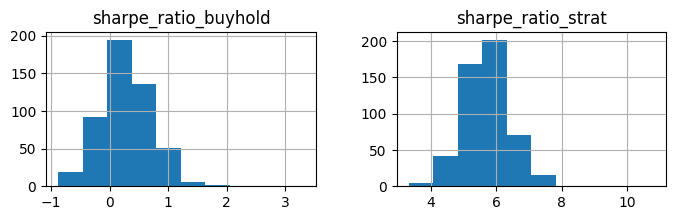

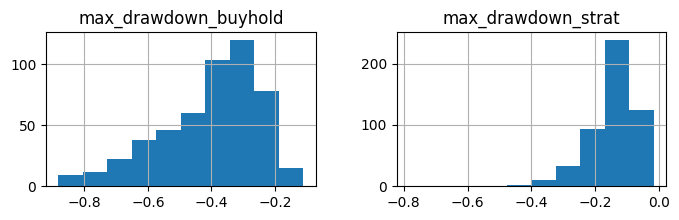

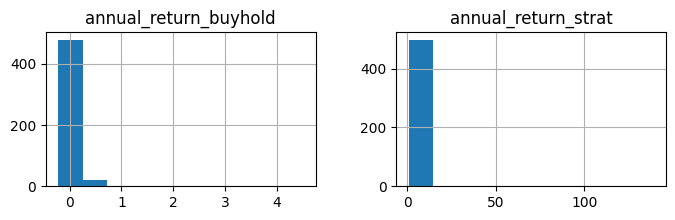

In [24]:
fig_x,fig_y=8,2
perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['sharpe_ratio_buyhold','sharpe_ratio_strat']].hist(bins=10,figsize=(fig_x,fig_y))
perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['max_drawdown_buyhold','max_drawdown_strat']].hist(bins=10,figsize=(fig_x,fig_y))
(perf_stats_pd.query(f'annual_return_strat>-10000 and annual_return_strat<10000')[['annual_return_buyhold','annual_return_strat']]*1).hist(bins=10,figsize=(fig_x,fig_y))

In [25]:
perf_stats_pd.query(f'annual_return_strat>-10000')[['symbol','annual_return_strat']].sort_values(['annual_return_strat']).style

,symbol,annual_return_strat
258,BRK.B,0.835056
427,VZ,0.904953
403,PEP,0.975389
152,MCD,0.996246
206,KO,1.009927
37,PG,1.017760
438,JNJ,1.024362
147,IBM,1.104211
4,CSCO,1.120026
342,MMC,1.158875


In [26]:
res_stats=first_last_df.groupBy('date').agg(py_f.sum("pnl").alias('daily_pnl'),
                                            (py_f.sum('conf_ind')/py_f.count('conf_ind')).alias('pct_right'),
                                            py_f.sum("eod_pct_change").alias('daily_pnl_buy_hold')
                                           ).toPandas()

<AxesSubplot:xlabel='date'>

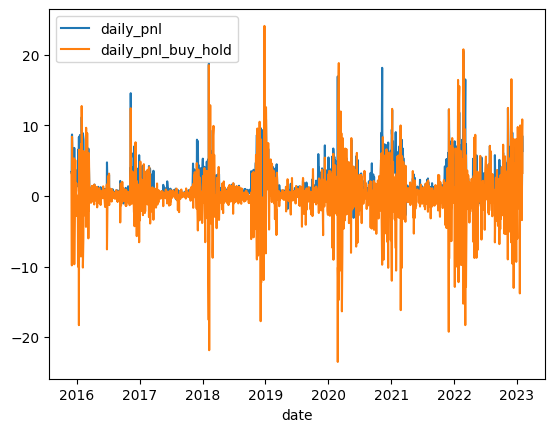

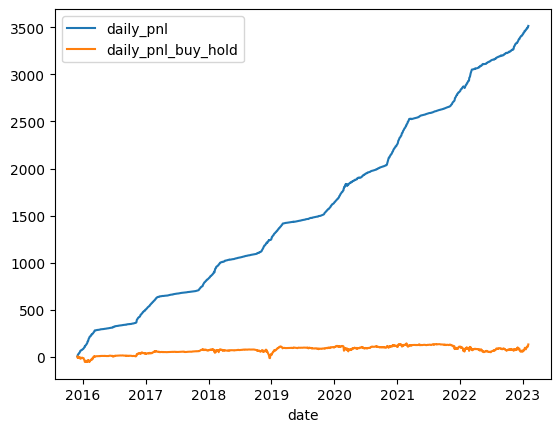

In [27]:
plot_col = ['daily_pnl','daily_pnl_buy_hold']
res_stats.set_index('date').sort_index()[plot_col].plot()#.cumsum().plot()
res_stats.set_index('date').sort_index()[plot_col].cumsum().plot()

<AxesSubplot:xlabel='date'>

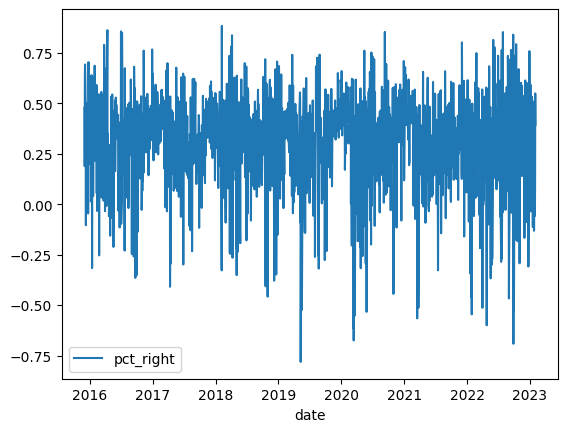

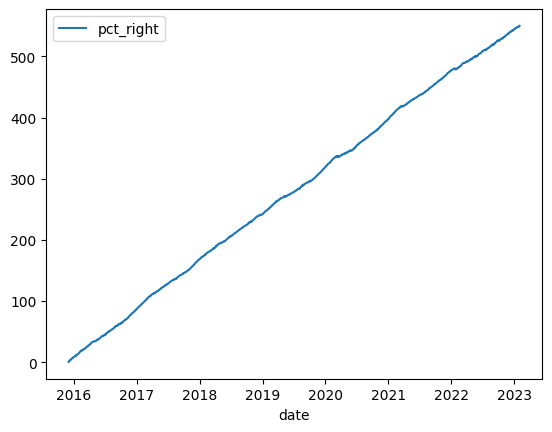

In [28]:
plot_col = 'pct_right'
res_stats.set_index('date').sort_index()[[plot_col]].plot()#.cumsum().plot()
res_stats.set_index('date').sort_index()[[plot_col]].cumsum().plot()

In [29]:
[i for i in vars(mdg)]

['shard_size',
 'fx_etf_symbols',
 'bitcoin_etf_symbols',
 'bitcoin_equity_proxy_symbols',
 'crypto_mining_symbols',
 'commod_etf_symbols',
 'fi_etf_symbols',
 'equity_share_class_pairs',
 'equity_etf_symbols',
 'sectors',
 'sp500',
 'bench_symbol',
 'all_symbols',
 'all_symbols_df',
 'columns_to_capture',
 'type_excl_field_map',
 'pandas_udf_schema',
 'data_folder',
 'parquet_file_out',
 'iex_token',
 'iex_ver',
 'iex_base_url',
 'old_df',
 'highwatermark_pd']

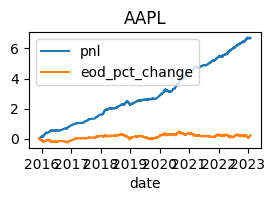

In [162]:
for one_sym in mdg.sp500:
    one_sym_pd = first_last_df.where(f"symbol=='{one_sym}'").toPandas().set_index('date').sort_index()
    if False:
        one_sym_pd[['pnl','eod_pct_change']].rolling(30*12).sum().plot(title=f'{one_sym}',figsize=(3,1.5))
    else:
        one_sym_pd[['pnl','eod_pct_change']].cumsum().plot(title=f'{one_sym}',figsize=(3,1.5))
    break

In [40]:
import vectorbt as vbt

one_day_pd = study_df.where("date == '2022-08-01'").toPandas().set_index('timestamp_utc').sort_index()
one_day_pd

,open,high,low,close,volume,trade_count,vwap,date,minute,symbol,is_last_bar,is_first_bar,is_random_check_bar,is_bench
timestamp_utc,,,,,,,,,,,,,,
2022-08-01 04:00:00,161.60,161.60,161.60,161.6000,120.0,1.0,161.600000,2022-08-01,04:00,AAPL,0,0,0,0
2022-08-01 04:00:00,278.83,278.83,278.83,278.8300,128.0,5.0,278.830000,2022-08-01,04:00,MSFT,0,0,0,0
2022-08-01 04:00:00,181.00,181.00,181.00,181.0000,174.0,1.0,181.000000,2022-08-01,04:00,NVDA,0,0,0,0
2022-08-01 04:00:00,94.70,94.70,94.70,94.7000,1500.0,2.0,94.700000,2022-08-01,04:00,AMD,0,0,0,0
2022-08-01 04:30:00,180.00,181.00,180.00,181.0000,317.0,7.0,180.410095,2022-08-01,04:30,NVDA,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01 23:30:00,45.78,45.78,45.70,45.7400,6863.0,45.0,45.737983,2022-08-01,23:30,ARKK,0,0,0,0
2022-08-01 23:30:00,184.61,184.80,184.45,184.7999,16948.0,240.0,184.617269,2022-08-01,23:30,NVDA,0,0,0,0
2022-08-01 23:30:00,124.00,124.00,123.65,123.6500,2488.0,14.0,123.910784,2022-08-01,23:30,ANET,0,0,0,0


In [95]:
def backtest_one_day(l_pd):
    l_pd['open_close_pct_change']=(l_pd['close']/l_pd['open'])-1
    l_pd = pd.pivot_table(l_pd,values=['close','open_close_pct_change'], index=['timestamp_utc','is_last_bar','is_first_bar'],columns=['symbol']).ffill()
    return(l_pd)

ret_pd =backtest_one_day(one_day_pd)
long_entry_pd = ((ret_pd.query('is_first_bar==1')>0)*1)
short_entry_pd = ((ret_pd.query('is_first_bar==1')<0)*-1)
exit_pd=((ret_pd.query('is_last_bar==1'))['close']==(ret_pd.query('is_last_bar==1'))['close'])
price_pd = ret_pd['close'].reset_index().drop(columns=['is_last_bar','is_first_bar']).set_index('timestamp_utc').sort_index()
price_pd.tail(3)

symbol,A,AAL,AAP,AAPL,AAXJ,ABBV,ABC,ABT,ACGL,ACN,...,XOM,XOP,XRAY,XSD,XYL,YUM,ZBH,ZBRA,ZION,ZTS
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2022-08-01 22:30:00,133.43,14.22,195.99,161.4600,67.41,140.49,145.93,109.52,43.49,304.74,...,94.40,134.02,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74
2022-08-01 23:00:00,133.80,14.23,195.99,161.4201,67.41,140.22,145.93,109.30,43.49,304.74,...,94.40,134.02,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74
2022-08-01 23:30:00,133.80,14.22,195.99,161.4000,67.41,140.22,145.93,109.30,43.49,304.74,...,94.56,133.70,35.98,181.9,91.2,123.5,109.76,358.43,53.93,179.74


In [102]:
type(price_pd)

pandas.core.frame.DataFrame

In [93]:
vbt.Portfolio.from_signals(price_pd,
                          )#,short_entries=short_entry_pd,long_entries=long_entry_pd,exits=exit_pd)

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [168]:
data_folder="s3://fsidatalake/eod_market_data/etf_trend_following/"
one_sym='SPY'
spy_pd = spark.read.parquet(f"{data_folder}{one_sym}.parquet").toPandas().set_index('date').sort_index()[['close']]
spy_pd

,close
date,
2006-12-29,141.62
2007-01-03,141.37
2007-01-04,141.67
2007-01-05,140.54
2007-01-08,141.19
...,...
2023-01-09,387.86
2023-01-10,390.58
2023-01-11,395.52


In [158]:
import vectorbt as vbt
aapl_data = vbt.YFData.download(
    'AAPL',
    interval='1d', 
    missing_index='drop',
    start='2022-01-01'
)
 
aapl_close = spy_pd#aapl_data.get('Close').to_frame()
#aapl_close.index=[(i.date()) for i in aapl_close.index]
fast_ma = vbt.MA.run(aapl_close, 10, short_name='fast MA')
slow_ma = vbt.MA.run(aapl_close, 50, short_name='fast MA')
long_entries = fast_ma.ma_crossed_above(slow_ma)
short_entries = fast_ma.ma_crossed_below(slow_ma)

pf = vbt.Portfolio.from_signals(
    aapl_close,
    entries=long_entries,
    short_entries=short_entries, 
    freq = '1d'
)
pf.stats()

AssertionError: Type must be <class 'vectorbt.utils.decorators.CacheCondition'>, not <class 'collections.CacheCondition'>

In [159]:
aapl_close

,Close
Date,
2022-01-03 05:00:00+00:00,180.959732
2022-01-04 05:00:00+00:00,178.663086
2022-01-05 05:00:00+00:00,173.910660
2022-01-06 05:00:00+00:00,171.007507
2022-01-07 05:00:00+00:00,171.176544
...,...
2023-02-06 05:00:00+00:00,151.729996
2023-02-07 05:00:00+00:00,154.649994
2023-02-08 05:00:00+00:00,151.919998


In [139]:
print(datetime.date(2022, 12, 25))

2022-12-25


In [ ]:
sym_sample_pd['open_close'] = (
    (sym_sample_pd['close'] / sym_sample_pd['open'] - 1
    )) * 100  #+(sym_sample_pd['marketClose']/sym_sample_pd['marketOpen']-1))/2
bench_sym = 'SPY'
bench_pd = sym_sample_pd.query(f"symbol=='{bench_sym}'")
join_cols = ['timestamp', 'date', 'minute']
bench_pd.columns = [
    f'{i}_bench' if i not in join_cols else i for i in bench_pd.columns
]
sym_sample_pd_tmp = bench_pd.set_index(join_cols).join(
    sym_sample_pd.set_index(join_cols))
open_min='14:30'
close_min='20:30'
sym_sample_first_last = sym_sample_pd_tmp.query(
    f'minute=="{open_min}" or minute=="{close_min}"')

sym_pd_pivot = pd.pivot_table(sym_sample_first_last,
                              values=[
                                  'open_close', 'open', 'close',
                                  'open_close_bench', 'open_bench',
                                  'close_bench'
                              ],
                              index=['symbol', 'date'],
                              columns=['minute'],
                              aggfunc='mean').dropna()
sym_pd_pivot.columns = [i.replace(":","") for i in  sym_pd_pivot.columns.to_series().str.join('_')]
open_min=open_min.replace(":","")
close_min=close_min.replace(":","")
sym_pd_pivot['day_change'] = (
    (sym_pd_pivot[f'close_{close_min}'] / sym_pd_pivot[f'close_{open_min}'] - 1)) * 100
sym_pd_pivot['day_change_bench'] = (
    (sym_pd_pivot[f'close_bench_{close_min}'] / sym_pd_pivot[f'close_bench_{open_min}'] -
     1)) * 100

sym_pd_pivot['day_vs_bench_change'] = sym_pd_pivot['day_change'] - sym_pd_pivot[
    'day_change_bench']
sym_pd_pivot[f'open_close_vs_bench_{open_min}'] = sym_pd_pivot[
    f'open_close_{open_min}'] - sym_pd_pivot[f'open_close_bench_{open_min}']
sym_pd_pivot[f'open_close_vs_bench_{close_min}'] = sym_pd_pivot[
    f'open_close_{close_min}'] - sym_pd_pivot[f'open_close_bench_{close_min}']

sym_pd_pivot[f'open_close_{open_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_{open_min}']
]
sym_pd_pivot[f'open_close_{close_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_{close_min}']
]
sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_vs_bench_{open_min}']
]
sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot[f'open_close_vs_bench_{close_min}']
]
sym_pd_pivot['day_change_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1) for x in sym_pd_pivot['day_change']
]
sym_pd_pivot['day_change_vs_bench_SIGN'] = [
    1 if x > 0 else (0 if x == 0 else -1)
    for x in sym_pd_pivot['day_vs_bench_change']
]

sym_pd_pivot['open_close_pnl']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_{close_min}'])+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_{close_min}'])*-1
sym_pd_pivot['day_change_pnl']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_change'])+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_change'])*-1
sym_pd_pivot['open_close_ind']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*-1
sym_pd_pivot['day_change_ind']= ((sym_pd_pivot[f'open_close_{open_min}_SIGN']==sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))+\
                                ((sym_pd_pivot[f'open_close_{open_min}_SIGN']!=sym_pd_pivot['day_change_SIGN'])*(sym_pd_pivot[f'open_close_{open_min}_SIGN']!=0))*-1

sym_pd_pivot['open_close_vs_bench_pnl']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_vs_bench_{close_min}'])+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot[f'open_close_vs_bench_{close_min}'])*-1
sym_pd_pivot['day_change_vs_bench_pnl']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_vs_bench_change'])+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*abs(sym_pd_pivot['day_vs_bench_change'])*-1
sym_pd_pivot['open_close_vs_bench_ind']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot[f'open_close_vs_bench_{close_min}_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*-1
sym_pd_pivot['day_change_vs_bench_ind']= ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']==sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))+\
                                         ((sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=sym_pd_pivot['day_change_vs_bench_SIGN'])*(sym_pd_pivot[f'open_close_vs_bench_{open_min}_SIGN']!=0))*-1

KeyError: "None of ['timestamp'] are in the columns"

In [ ]:
strat_stats = sym_pd_pivot.reset_index().groupby([
    'symbol', f'open_close_{open_min}_SIGN'
]).agg({
    'open_close_pnl': ['count', 'mean', 'sum'],
    'day_change_pnl': ['mean', 'sum'],
    'open_close_vs_bench_pnl':['mean','sum'],
    'day_change_vs_bench_pnl':['mean','sum'],
    #'open_close_vs_bench_ind': ['mean', 'sum'],
    #'day_change_vs_bench_ind': ['mean', 'sum'],
    #'open_close_ind': ['mean', 'sum'],
    #'day_change_ind': ['mean', 'sum'],
    'date': ['min', 'max']
})
strat_stats.columns = strat_stats.columns.to_series().str.join('_')
trade_dir=1
pnl_f='day_change_vs_bench_pnl'
pos_pd = strat_stats.query(f"open_close_pnl_count>200 & {pnl_f}_mean>0.01 & open_close_{open_min}_SIGN=={trade_dir}").sort_index()
pos_pd.style

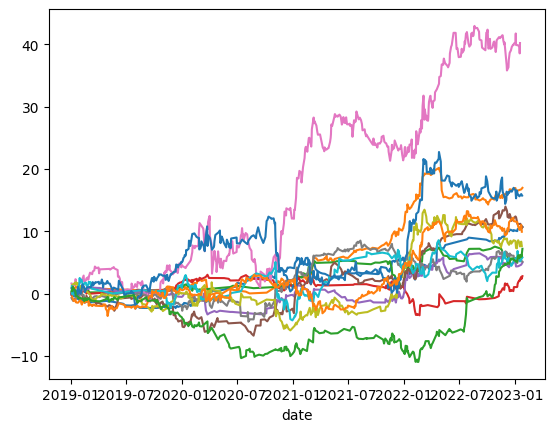

In [ ]:
res_check_arr= []

for symbol_check in pos_pd.reset_index().symbol:
    l_pd = sym_pd_pivot[sym_pd_pivot[f'open_close_{open_min}_SIGN'] == 1].query(
        f'symbol=="{symbol_check}"').reset_index().set_index('date')
    res_check_arr=res_check_arr+[l_pd[['symbol',pnl_f]]]
    l_pd[pnl_f].cumsum().plot()

#pf.create_returns_tear_sheet(l_pd['day_change_pnl']/ 100)

<AxesSubplot:xlabel='date'>

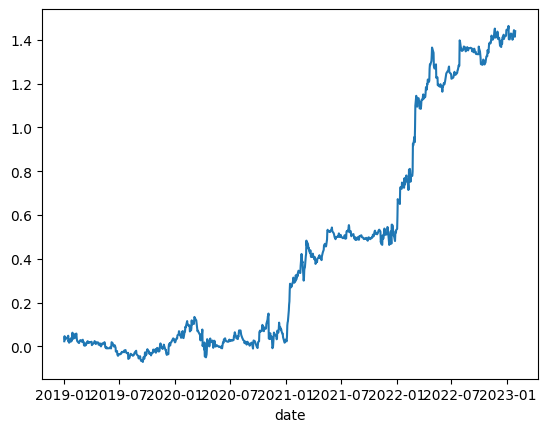

In [ ]:
portf_pnl=pd.pivot_table(pd.concat(res_check_arr), values=[ pnl_f ],
                              index=[ 'date'],
                              columns=['symbol'],
                              aggfunc='mean' )
portf_pnl['daily_pnl']=portf_pnl.sum(axis=1)/100
portf_pnl['daily_pnl'].cumsum().plot()

<AxesSubplot:xlabel='date'>

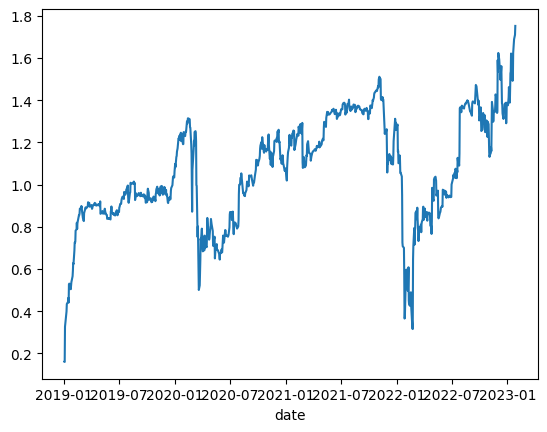

In [ ]:
portf_pnl=pd.pivot_table(pd.concat(res_check_arr), values=[ pnl_f ],
                              index=[ 'date'],
                              columns=['symbol'],
                              aggfunc='mean' )
portf_pnl['daily_pnl']=portf_pnl.sum(axis=1)/100
portf_pnl['daily_pnl'].cumsum().plot()

In [ ]:
pf.create_returns_tear_sheet(portf_pnl['daily_pnl'])

Start date,2019-01-02
End date,2023-01-27
Total months,45
,Backtest
Annual return,26.9%
Cumulative returns,147.5%
Annual volatility,66.0%
Sharpe ratio,0.70
Calmar ratio,0.35
Stability,0.14
Max drawdown,-77.3%


AttributeError: 'datetime.date' object has no attribute 'to_pydatetime'